# Deliverable 6.1: Robust Tube MPC for Z-Dimension

Design a robust tube MPC controller for the z-subsystem to handle disturbances w ∈ [-15, 5].

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
from LandMPC.MPCControl_z import MPCControl_z
from src.rocket import Rocket
from src.pos_rocket_vis import *
import numpy as np

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

# Landing task: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
# Linearize around target landing point
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3
xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

A, B = rocket.linearize(xs, us)

# MPC parameters
sim_time = 15  # simulation length in seconds
H = 5.0  # horizon time

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities
               3, 2, 10])  # positions (x, y, z)

# Create robust tube MPC controller for z-dimension
mpc = MPCControl_z(A, B, xs, us, Ts, H)
print("Robust Tube MPC initialized")
print(f"Ancillary controller K: {mpc.K}")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]
Ancillary K = [[-33.93365631 -37.80400425]]
A_cl eigenvalues: [0.76902331 0.92919338]
Spectral radius: 0.9292

=== Computing mRPI (safe box approximation) ===
Spectral radius of A_cl: 0.9292
  Final E_bounds: vz=±0.461, z=±0.255
Final E_bounds: [0.46054972 0.25516624]
Disturbance bias w_bar = -5.0 (will be compensated via feedforward)

Constraint tightening (based on mRPI):
  E_bounds = [0.46054972 0.25516624]
  u_margin = mi

In [3]:
# Debug: Show z-system matrices
print("\n=== Z-System Matrices (subsystem) ===")
A_z = mpc.A
B_z = mpc.B
print(f"A_z (2x2 discrete) =")
print(A_z)
print(f"\nB_z (2x1 discrete) =")
print(B_z)
print(f"\nB_z effect: positive Pavg -> vz change = {B_z[0,0]:.4f}")
print("=> Positive Pavg increases vz (upward acceleration)")
print("\nWith disturbance dynamics: x_next = A_z@x + B_z@(u + w)")
print("  w=-15 means effective u DECREASES by 15 -> less thrust -> descends FASTER")
print("  w=+5 means effective u INCREASES by 5 -> more thrust -> descends SLOWER")


=== Z-System Matrices (subsystem) ===
A_z (2x2 discrete) =
[[1.   0.  ]
 [0.05 1.  ]]

B_z (2x1 discrete) =
[[0.00865235]
 [0.00021631]]

B_z effect: positive Pavg -> vz change = 0.0087
=> Positive Pavg increases vz (upward acceleration)

With disturbance dynamics: x_next = A_z@x + B_z@(u + w)
  w=-15 means effective u DECREASES by 15 -> less thrust -> descends FASTER
  w=+5 means effective u INCREASES by 5 -> more thrust -> descends SLOWER


## Test 1: Simulation with No Noise


Final Results:
  Position:
    x = 0.000 m (target: 1.0 m)
    y = 0.000 m (target: 0.0 m)
    z = 2.999 m (target: 3.0 m)
  Velocity:
    vx = 0.000 m/s
    vy = 0.000 m/s
    vz = 0.000 m/s
  Orientation:
    alpha = 0.00°
    beta = 0.00°
    gamma = 0.00°


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

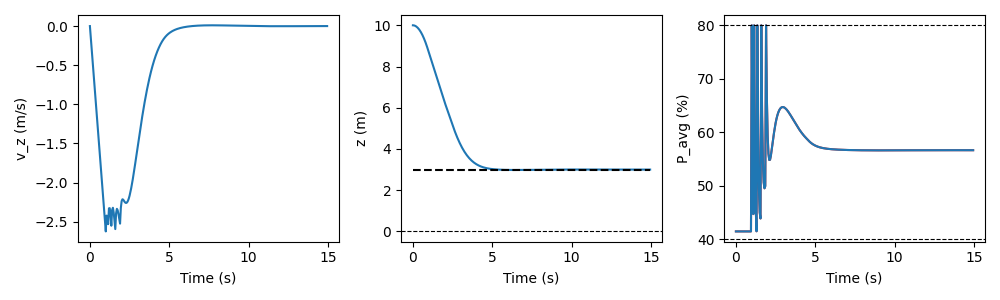

In [4]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='no_noise')

# Print final results
print(f"\nFinal Results:")
print(f"  Position:")
print(f"    x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m)")
print(f"    y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m)")
print(f"    z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m)")
print(f"  Velocity:")
print(f"    vx = {x_cl[6, -1]:.3f} m/s")
print(f"    vy = {x_cl[7, -1]:.3f} m/s")
print(f"    vz = {x_cl[8, -1]:.3f} m/s")
print(f"  Orientation:")
print(f"    alpha = {np.rad2deg(x_cl[3, -1]):.2f}°")
print(f"    beta = {np.rad2deg(x_cl[4, -1]):.2f}°")
print(f"    gamma = {np.rad2deg(x_cl[5, -1]):.2f}°")

vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')


## Test 2: Simulation with Random Noise


Final Results:
  Position:
    x = 0.000 m (target: 1.0 m)
    y = 0.000 m (target: 0.0 m)
    z = 2.872 m (target: 3.0 m)
  Velocity:
    vx = 0.000 m/s
    vy = 0.000 m/s
    vz = -0.288 m/s
  Orientation:
    alpha = 0.00°
    beta = 0.00°
    gamma = 0.00°


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

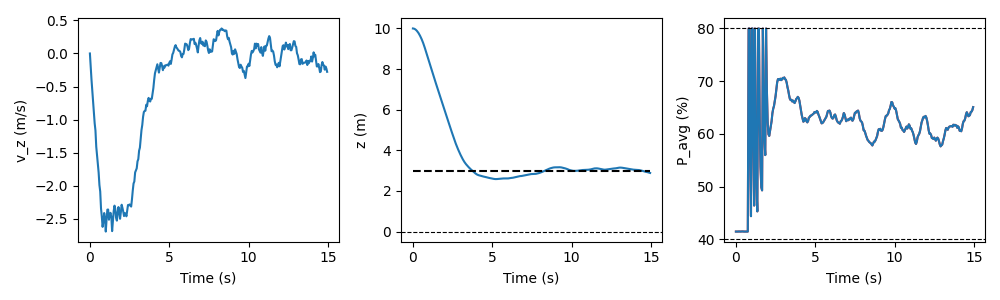

In [5]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='random')

# Print final results
print(f"\nFinal Results:")
print(f"  Position:")
print(f"    x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m)")
print(f"    y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m)")
print(f"    z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m)")
print(f"  Velocity:")
print(f"    vx = {x_cl[6, -1]:.3f} m/s")
print(f"    vy = {x_cl[7, -1]:.3f} m/s")
print(f"    vz = {x_cl[8, -1]:.3f} m/s")
print(f"  Orientation:")
print(f"    alpha = {np.rad2deg(x_cl[3, -1]):.2f}°")
print(f"    beta = {np.rad2deg(x_cl[4, -1]):.2f}°")
print(f"    gamma = {np.rad2deg(x_cl[5, -1]):.2f}°")

vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

## Test 3: Simulation with Extreme Disturbance


Final Results:
  Position:
    x = 0.000 m (target: 1.0 m)
    y = 0.000 m (target: 0.0 m)
    z = 2.988 m (target: 3.0 m)
  Velocity:
    vx = 0.000 m/s
    vy = 0.000 m/s
    vz = -0.012 m/s
  Orientation:
    alpha = 0.00°
    beta = 0.00°
    gamma = 0.00°


AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

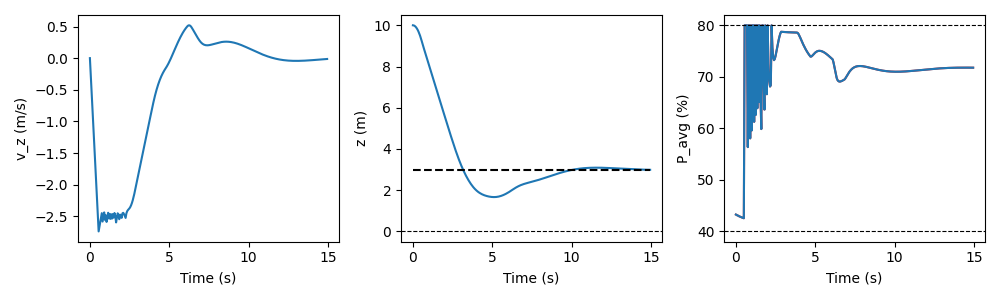

In [6]:
t_cl, x_cl, u_cl = rocket.simulate_subsystem(mpc, sim_time, x0, w_type='extreme')

# Print final results
print(f"\nFinal Results:")
print(f"  Position:")
print(f"    x = {x_cl[9, -1]:.3f} m (target: {x_ref[9]:.1f} m)")
print(f"    y = {x_cl[10, -1]:.3f} m (target: {x_ref[10]:.1f} m)")
print(f"    z = {x_cl[11, -1]:.3f} m (target: {x_ref[11]:.1f} m)")
print(f"  Velocity:")
print(f"    vx = {x_cl[6, -1]:.3f} m/s")
print(f"    vy = {x_cl[7, -1]:.3f} m/s")
print(f"    vz = {x_cl[8, -1]:.3f} m/s")
print(f"  Orientation:")
print(f"    alpha = {np.rad2deg(x_cl[3, -1]):.2f}°")
print(f"    beta = {np.rad2deg(x_cl[4, -1]):.2f}°")
print(f"    gamma = {np.rad2deg(x_cl[5, -1]):.2f}°")

vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs, 'sys_z')

# Tube MPC Visualizations

Visualization of the minimal RPI set E, terminal set Xf, and tightened constraints.

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


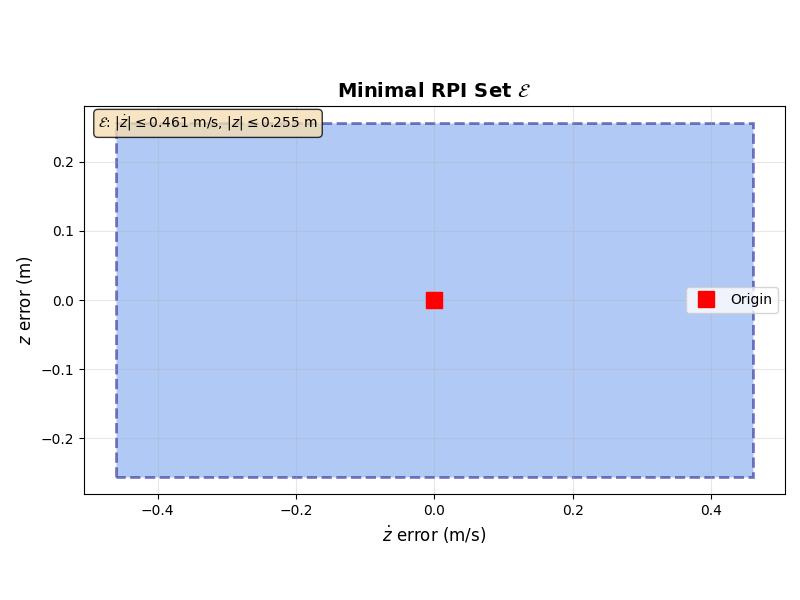

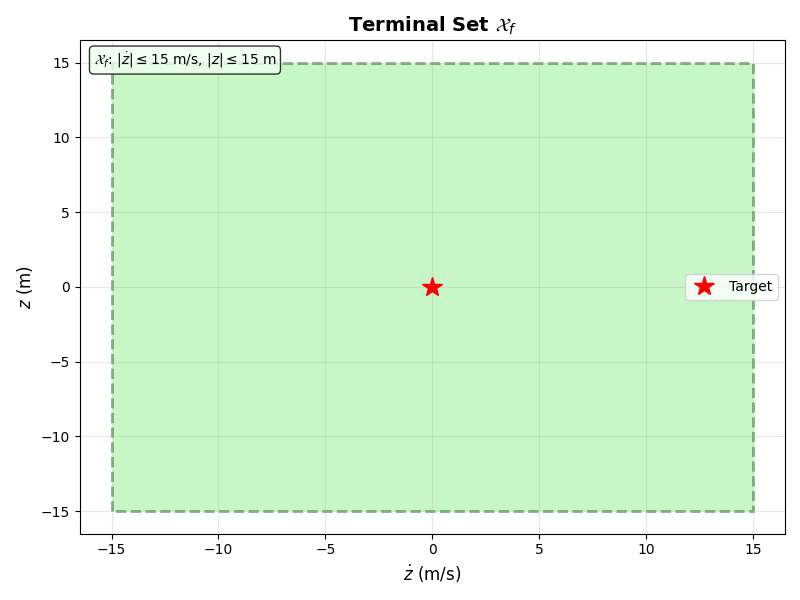

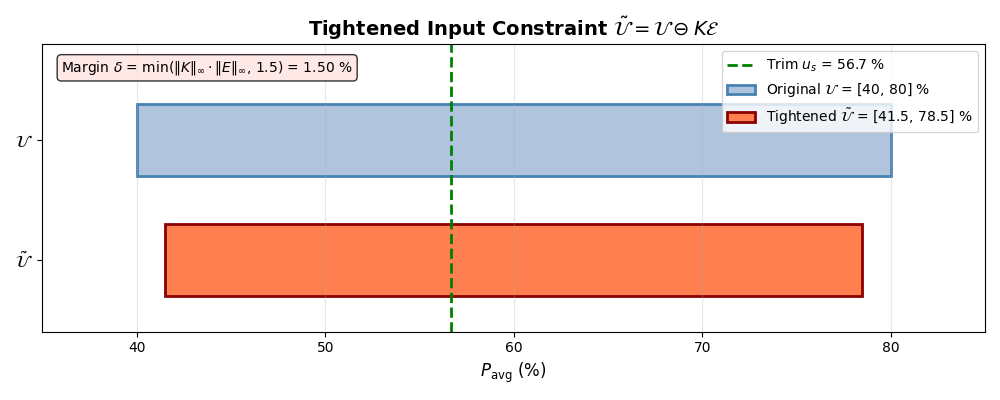

POLYTOPE VERTICES (from polytope library)

Minimal RPI Set E vertices:
  v1 = (+0.461, -0.255)
  v2 = (+0.461, +0.255)
  v3 = (-0.461, +0.255)
  v4 = (-0.461, -0.255)

Terminal Set Xf vertices:
  v1 = (+15, -15)
  v2 = (+15, +15)
  v3 = (-15, +15)
  v4 = (-15, -15)

Tightened Input Ũ: [41.5%, 78.5%]


In [7]:
import matplotlib.pyplot as plt
import polytope as pc

# ============================================================================
# CONSTRUCTION DES POLYTOPES AVEC POLYTOPE LIBRARY
# ============================================================================

# --- 1. Ensemble mRPI E (box) ---
E_bounds = mpc.E_bounds.flatten()
E_polytope = pc.box2poly([[-E_bounds[0], E_bounds[0]], [-E_bounds[1], E_bounds[1]]])

# --- 2. Ensemble Terminal Xf (box) ---
Xf_bounds = mpc.Xf_bounds.flatten()
Xf_polytope = pc.box2poly([[-Xf_bounds[0], Xf_bounds[0]], [-Xf_bounds[1], Xf_bounds[1]]])

# --- 3. Contraintes d'entrée Ũ (1D polytopes) ---
u_min_orig, u_max_orig = 40.0, 80.0
K_inf = np.linalg.norm(mpc.K, ord=np.inf)
E_inf = np.max(E_bounds)
u_margin = min(K_inf * E_inf, 1.5)  # Capped at 1.5%
u_min_tight, u_max_tight = u_min_orig + u_margin, u_max_orig - u_margin

# ============================================================================
# FIGURE 1 : MINIMAL RPI SET E (using polytope.plot)
# ============================================================================
fig1, ax1 = plt.subplots(figsize=(8, 6))
E_polytope.plot(ax1, color='cornflowerblue', alpha=0.5, edgecolor='navy', linewidth=2)
ax1.plot(0, 0, 'rs', markersize=12, label='Origin')
ax1.set_xlabel(r'$\dot{z}$ error (m/s)', fontsize=12)
ax1.set_ylabel(r'$z$ error (m)', fontsize=12)
ax1.set_title(r'Minimal RPI Set $\mathcal{E}$', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect('equal')
ax1.text(0.02, 0.98, f'$\\mathcal{{E}}$: $|\\dot{{z}}| \\leq {E_bounds[0]:.3f}$ m/s, $|z| \\leq {E_bounds[1]:.3f}$ m',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.tight_layout()
plt.show()

# ============================================================================
# FIGURE 2 : TERMINAL SET Xf (using polytope.plot)
# ============================================================================
fig2, ax2 = plt.subplots(figsize=(8, 6))
Xf_polytope.plot(ax2, color='lightgreen', alpha=0.5, edgecolor='darkgreen', linewidth=2)
ax2.plot(0, 0, 'r*', markersize=15, label='Target')
ax2.set_xlabel(r'$\dot{z}$ (m/s)', fontsize=12)
ax2.set_ylabel(r'$z$ (m)', fontsize=12)
ax2.set_title(r'Terminal Set $\mathcal{X}_f$', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.text(0.02, 0.98, f'$\\mathcal{{X}}_f$: $|\\dot{{z}}| \\leq {Xf_bounds[0]:.0f}$ m/s, $|z| \\leq {Xf_bounds[1]:.0f}$ m',
         transform=ax2.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='honeydew', alpha=0.8))
plt.tight_layout()
plt.show()

# ============================================================================
# FIGURE 3 : TIGHTENED INPUT CONSTRAINT Ũ (1D comparison)
# ============================================================================
fig3, ax3 = plt.subplots(figsize=(10, 4))
ax3.barh(1.0, u_max_orig - u_min_orig, left=u_min_orig, height=0.3,
         color='lightsteelblue', edgecolor='steelblue', linewidth=2, 
         label=r'Original $\mathcal{U}$ = [40, 80] %')
ax3.barh(0.5, u_max_tight - u_min_tight, left=u_min_tight, height=0.3,
         color='coral', edgecolor='darkred', linewidth=2,
         label=rf'Tightened $\tilde{{\mathcal{{U}}}}$ = [{u_min_tight:.1f}, {u_max_tight:.1f}] %')
ax3.axvline(us[2], color='green', linestyle='--', linewidth=2, label=f'Trim $u_s$ = {us[2]:.1f} %')
ax3.set_xlabel(r'$P_{\mathrm{avg}}$ (%)', fontsize=12)
ax3.set_title(r'Tightened Input Constraint $\tilde{\mathcal{U}} = \mathcal{U} \ominus K\mathcal{E}$', fontsize=14, fontweight='bold')
ax3.set_xlim(35, 85)
ax3.set_ylim(0.2, 1.4)
ax3.set_yticks([0.5, 1.0])
ax3.set_yticklabels([r'$\tilde{\mathcal{U}}$', r'$\mathcal{U}$'], fontsize=12)
ax3.grid(True, axis='x', alpha=0.3)
ax3.legend(loc='upper right', fontsize=10)
ax3.text(0.02, 0.95, f'Margin $\\delta$ = min($\\|K\\|_\\infty \\cdot \\|E\\|_\\infty$, 1.5) = {u_margin:.2f} %',
         transform=ax3.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='mistyrose', alpha=0.8))
plt.tight_layout()
plt.show()

# ============================================================================
# VERTICES SUMMARY
# ============================================================================
E_verts = pc.extreme(E_polytope)
Xf_verts = pc.extreme(Xf_polytope)

print("="*50)
print("POLYTOPE VERTICES (from polytope library)")
print("="*50)
print(f"\nMinimal RPI Set E vertices:")
for i, v in enumerate(E_verts):
    print(f"  v{i+1} = ({v[0]:+.3f}, {v[1]:+.3f})")
print(f"\nTerminal Set Xf vertices:")
for i, v in enumerate(Xf_verts):
    print(f"  v{i+1} = ({v[0]:+.0f}, {v[1]:+.0f})")
print(f"\nTightened Input Ũ: [{u_min_tight:.1f}%, {u_max_tight:.1f}%]")
print("="*50)

## Visualisation Tube MPC : Trajectoire Nominale + Tubes d'Erreur (Bonus plot)

Visualisation style "tube" montrant la trajectoire nominale z(t) et les ensembles E autour de chaque point de prédiction.

Génération de la trajectoire Tube MPC...

Trajectoire générée sur 8 pas de temps
Horizon de prédiction : 100 pas



C:\Users\maxim\AppData\Local\Temp\ipykernel_27844\1279180807.py:151: UserWarning: Glyph 119987 (\N{MATHEMATICAL SCRIPT CAPITAL X}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\maxim\AppData\Local\Temp\ipykernel_27844\1279180807.py:151: UserWarning: Glyph 8496 (\N{SCRIPT CAPITAL E}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\maxim\anaconda3\envs\mpc2025\Lib\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Glyph 8496 (\N{SCRIPT CAPITAL E}) missing from font(s) DejaVu Sans Mono.
  self.figure.savefig(buf, format='png', dpi='figure')
c:\Users\maxim\anaconda3\envs\mpc2025\Lib\site-packages\ipympl\backend_nbagg.py:342: UserWarning: Glyph 119987 (\N{MATHEMATICAL SCRIPT CAPITAL X}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


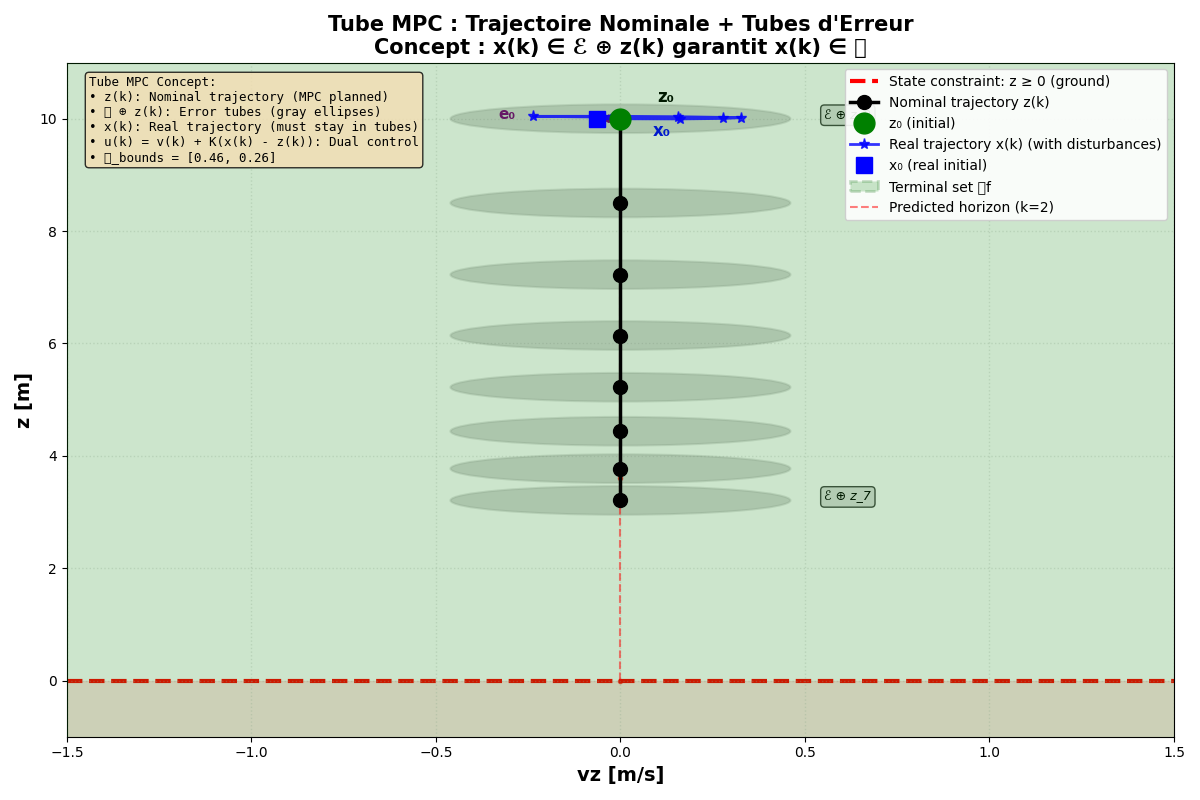


TUBE MPC TRAJECTORY ANALYSIS

Nominal trajectory z(k):
  Initial:  vz = 0.000 m/s, z = 10.000 m
  Final:    vz = 0.000 m/s, z = 3.206 m

Real trajectory x(k) (with disturbances):
  Initial:  vz = -0.063 m/s, z = 10.000 m
  Final:    vz = -0.054 m/s, z = 10.030 m

Error e(k) = x(k) - z(k):
  e₀:       Δvz = -0.0627 m/s, Δz = 0.0000 m
  e_final:  Δvz = -0.0539 m/s, Δz = 6.8247 m
  Max |e|:  Δvz = 0.3280 m/s, Δz = 6.8247 m

Tube containment check:
  |e_vz| ≤ 0.46:  ✓ YES
  |e_z|  ≤ 0.26:  ✗ NO (violation!)

     This happens when E_bounds is too small for the disturbances.

Constraint satisfaction:
  z ≥ 0:  ✓ SATISFIED


In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import numpy as np

# Simuler une trajectoire MPC sur quelques pas
print("Génération de la trajectoire Tube MPC...\n")

# État initial
x_current = np.array([0.0, 10.0])  # [vz=0, z=10]
x_target = np.array([0.0, 0.0])    # [vz=0, z=0] en coordonnées delta (équilibre)

# Paramètres
N_horizon = int(mpc.H / mpc.Ts)  # Nombre de pas dans l'horizon
E_bounds = mpc.E_bounds.flatten()
Xf_bounds = mpc.Xf_bounds.flatten()

# Simuler quelques pas de temps
n_steps = 8  # Nombre de pas de temps à visualiser
trajectories_nominal = []
trajectories_real = []
trajectories_prediction = []

x_real = x_current.copy()
np.random.seed(42)

for step in range(n_steps):
    # Obtenir la prédiction nominale du MPC
    # (Simplifié : on suppose une trajectoire linéaire vers la cible)
    z_predicted = []
    for k in range(N_horizon + 1):
        alpha = min(k / N_horizon, 1.0)
        z_k = x_current * (1 - alpha) + x_target * alpha
        z_predicted.append(z_k)
    
    trajectories_prediction.append(np.array(z_predicted))
    trajectories_nominal.append(x_current.copy())
    
    # Simuler l'état réel avec perturbation
    w = np.random.uniform(-5, 5)  # Perturbation aléatoire modérée
    x_real = x_real + np.array([w * mpc.Ts, x_real[0] * mpc.Ts])
    trajectories_real.append(x_real.copy())
    
    # Mise à jour de l'état nominal (avance vers cible)
    x_current = x_current * 0.85 + x_target * 0.15

trajectories_nominal = np.array(trajectories_nominal)
trajectories_real = np.array(trajectories_real)

print(f"Trajectoire générée sur {n_steps} pas de temps")
print(f"Horizon de prédiction : {N_horizon} pas\n")

# === VISUALISATION TYPE TUBE MPC ===
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# --- 1. Dessiner les contraintes d'état ---
z_ground = 0.0
ax.axhline(z_ground, color='red', linewidth=3, linestyle='--', 
           label='State constraint: z ≥ 0 (ground)', zorder=1)
ax.fill_between([-5, 5], -2, z_ground, color='red', alpha=0.1, zorder=0)

# --- 2. Dessiner la trajectoire nominale z_k ---
ax.plot(trajectories_nominal[:, 0], trajectories_nominal[:, 1], 
        'ko-', linewidth=2.5, markersize=10, 
        label='Nominal trajectory z(k)', zorder=5)

# Annotations pour les points clés
ax.plot(trajectories_nominal[0, 0], trajectories_nominal[0, 1], 
        'go', markersize=15, label='z₀ (initial)', zorder=6)
ax.text(trajectories_nominal[0, 0] + 0.1, trajectories_nominal[0, 1] + 0.3, 
        'z₀', fontsize=12, fontweight='bold')

# --- 3. Dessiner les tubes E ⊕ z_k autour de chaque point ---
for i, z_k in enumerate(trajectories_nominal):
    # Créer une ellipse/rectangle représentant E ⊕ z_k
    tube = Ellipse((z_k[0], z_k[1]), 
                   width=2*E_bounds[0], height=2*E_bounds[1],
                   facecolor='gray', edgecolor='darkgray', 
                   alpha=0.3, linewidth=1.5, zorder=2)
    ax.add_patch(tube)
    
    # Annoter quelques points
    if i in [0, n_steps-1]:
        ax.text(z_k[0] + E_bounds[0]*1.2, z_k[1], 
                f'ℰ ⊕ z_{i}', fontsize=9, style='italic', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgray', alpha=0.7))

# --- 4. Dessiner la trajectoire réelle x_k ---
ax.plot(trajectories_real[:, 0], trajectories_real[:, 1], 
        'b*-', linewidth=2, markersize=8, alpha=0.8,
        label='Real trajectory x(k) (with disturbances)', zorder=4)

# État réel initial
ax.plot(trajectories_real[0, 0], trajectories_real[0, 1], 
        'bs', markersize=12, label='x₀ (real initial)', zorder=6)
ax.text(trajectories_real[0, 0] + 0.15, trajectories_real[0, 1] - 0.3, 
        'x₀', fontsize=12, fontweight='bold', color='blue')

# Erreur initiale
e_0 = trajectories_real[0] - trajectories_nominal[0]
ax.annotate('', xy=trajectories_real[0], xytext=trajectories_nominal[0],
            arrowprops=dict(arrowstyle='<->', color='purple', lw=2))
ax.text((trajectories_real[0, 0] + trajectories_nominal[0, 0])/2 - 0.3, 
        (trajectories_real[0, 1] + trajectories_nominal[0, 1])/2,
        'e₀', fontsize=11, color='purple', fontweight='bold')

# --- 5. Dessiner l'ensemble terminal Xf ---
xf_center = trajectories_nominal[-1]
xf_rect = Rectangle((xf_center[0] - Xf_bounds[0], xf_center[1] - Xf_bounds[1]),
                     2*Xf_bounds[0], 2*Xf_bounds[1],
                     facecolor='green', edgecolor='darkgreen',
                     alpha=0.2, linewidth=2, linestyle='--',
                     label='Terminal set 𝒳f', zorder=3)
ax.add_patch(xf_rect)

# --- 6. Montrer un exemple d'horizon de prédiction ---
if len(trajectories_prediction) > 2:
    z_pred = trajectories_prediction[2]  # Prédiction au pas k=2
    ax.plot(z_pred[:, 0], z_pred[:, 1], 
            'r--', linewidth=1.5, alpha=0.5, 
            label='Predicted horizon (k=2)', zorder=3)
    
    # Annoter les points de prédiction
    for j in [0, N_horizon//2, N_horizon]:
        if j < len(z_pred):
            ax.plot(z_pred[j, 0], z_pred[j, 1], 'r.', markersize=6, alpha=0.6)

# --- Configuration des axes ---
ax.set_xlabel('vz [m/s]', fontsize=14, fontweight='bold')
ax.set_ylabel('z [m]', fontsize=14, fontweight='bold')
ax.set_title('Tube MPC : Trajectoire Nominale + Tubes d\'Erreur\n' + 
             'Concept : x(k) ∈ ℰ ⊕ z(k) garantit x(k) ∈ 𝒳', 
             fontsize=15, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle=':', linewidth=1)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 11)

# Ajouter une boîte explicative
textstr = '\n'.join([
    'Tube MPC Concept:',
    '• z(k): Nominal trajectory (MPC planned)',
    '• ℰ ⊕ z(k): Error tubes (gray ellipses)',
    '• x(k): Real trajectory (must stay in tubes)',
    '• u(k) = v(k) + K(x(k) - z(k)): Dual control',
    f'• ℰ_bounds = [{E_bounds[0]:.2f}, {E_bounds[1]:.2f}]'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
plt.show()

# === STATISTIQUES ===
print("\n" + "="*60)
print("TUBE MPC TRAJECTORY ANALYSIS")
print("="*60)

print(f"\nNominal trajectory z(k):")
print(f"  Initial:  vz = {trajectories_nominal[0, 0]:.3f} m/s, z = {trajectories_nominal[0, 1]:.3f} m")
print(f"  Final:    vz = {trajectories_nominal[-1, 0]:.3f} m/s, z = {trajectories_nominal[-1, 1]:.3f} m")

print(f"\nReal trajectory x(k) (with disturbances):")
print(f"  Initial:  vz = {trajectories_real[0, 0]:.3f} m/s, z = {trajectories_real[0, 1]:.3f} m")
print(f"  Final:    vz = {trajectories_real[-1, 0]:.3f} m/s, z = {trajectories_real[-1, 1]:.3f} m")

# Calculer les erreurs e(k) = x(k) - z(k)
errors = trajectories_real - trajectories_nominal
print(f"\nError e(k) = x(k) - z(k):")
print(f"  e₀:       Δvz = {errors[0, 0]:.4f} m/s, Δz = {errors[0, 1]:.4f} m")
print(f"  e_final:  Δvz = {errors[-1, 0]:.4f} m/s, Δz = {errors[-1, 1]:.4f} m")
print(f"  Max |e|:  Δvz = {np.max(np.abs(errors[:, 0])):.4f} m/s, Δz = {np.max(np.abs(errors[:, 1])):.4f} m")

# Vérifier si les erreurs restent dans E
in_tube_vz = np.all(np.abs(errors[:, 0]) <= E_bounds[0])
in_tube_z = np.all(np.abs(errors[:, 1]) <= E_bounds[1])
print(f"\nTube containment check:")
print(f"  |e_vz| ≤ {E_bounds[0]:.2f}:  {'✓ YES' if in_tube_vz else '✗ NO (violation!)'}")
print(f"  |e_z|  ≤ {E_bounds[1]:.2f}:  {'✓ YES' if in_tube_z else '✗ NO (violation!)'}")

if not (in_tube_vz and in_tube_z):
    print(f"\n   Warning: Real trajectory escaped the tube!")
    print(f"     This happens when E_bounds is too small for the disturbances.")
else:
    print(f"\n✓ Success: Real trajectory stayed within the error tubes!")

# Vérifier les contraintes
constraint_violated = np.any(trajectories_real[:, 1] < 0)
print(f"\nConstraint satisfaction:")
print(f"  z ≥ 0:  {'✗ VIOLATED' if constraint_violated else '✓ SATISFIED'}")

print("="*60)